In [1]:
import pathlib
import dask.dataframe
import psutil
import requests, re
import pandas as pd

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 172.98 GB


In [3]:
# using pathlib create directory called meteo
data_dir = pathlib.Path("meteo")
data_dir.mkdir(exist_ok=True)

In [4]:
base = "https://meteo.gig.eu/archiwum/2025/"
dest = pathlib.Path("meteo")
dest.mkdir(exist_ok=True)
html = requests.get(base).text
files = re.findall(r'href="([^"]+\.\w+)"', html)
for f in files:
    url = f if f.startswith("http") else base + f
    name = pathlib.Path(url).name
    print("Downloading", name)
    with requests.get(url, stream=True) as r, open(dest/name, "wb") as out:
        for chunk in r.iter_content(1024*64):
            out.write(chunk)

In [5]:
first_file = next(data_dir.glob("*.txt"))
first_file

PosixPath('meteo/20250519.txt')

In [6]:
columns = [
    "Date",
    "Time",
    "TempOut",
    "TempHi",
    "TempLow",
    "HumOut",
    "DewPt",
    "WindSpeed",
    "WindDir",
    "WindRun",
    "WindSpeedHi",
    "WindDirHi",
    "WindChill",
    "HeatIndex",
    "THWIndex",
    "THSWIndex",
    "Bar",
    "Rain",
    "RainRate",
    "SolarRad",
    "SolarEnergy",
    "SolarRadHi",
    "UVIndex",
    "UVDose",
    "UVIndexHi",
    "HeatDD",
    "CoolDD",
    "TempIn",
    "HumIn",
    "DewPtIn",
    "HeatIn",
    "ET",
    "WindSamp",
    "WindTx",
    "ISSRecept",
    "ArcInt"
]

In [7]:
df = pd.read_csv(first_file,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
df.head()

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,25-05-11,0:30,8.5,8.7,8.3,85,6.1,0.4,N,0.80,...,0.0,21.6,31,3.7,19.9,0.0,697,1,100.0,30
1,25-05-11,1:00,8.1,8.3,7.9,87,6.0,0.4,N,0.80,...,0.0,21.6,31,3.7,19.8,0.0,700,1,100.0,30
2,25-05-11,1:30,7.8,7.9,7.7,87,5.7,0.4,N,0.80,...,0.0,21.5,31,3.6,19.8,0.0,699,1,100.0,30
3,25-05-11,2:00,7.7,7.7,7.6,86,5.5,0.9,N,1.61,...,0.0,21.4,31,3.6,19.7,0.0,701,1,100.0,30
4,25-05-11,2:30,7.6,7.7,7.3,86,5.4,0.9,N,1.61,...,0.0,21.4,31,3.6,19.7,0.0,699,1,100.0,30


<Axes: xlabel='TempOut', ylabel='HumOut'>

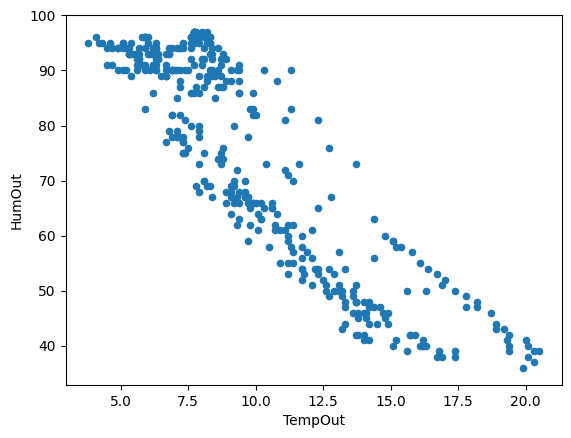

In [8]:
df.plot.scatter(x='TempOut',y='HumOut')

In [9]:
df_list = []
for file_path in data_dir.glob("*.txt"):
    df_tmp = pd.read_csv(file_path,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
    df_list.append(df_tmp)
df_all = pd.concat(df_list)
df_all

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,25-05-11,0:30,8.5,8.7,8.3,85.0,6.1,0.4,N,0.80,...,0.0,21.6,31.0,3.7,19.9,0.00,697,1,100.0,30
1,25-05-11,1:00,8.1,8.3,7.9,87.0,6.0,0.4,N,0.80,...,0.0,21.6,31.0,3.7,19.8,0.00,700,1,100.0,30
2,25-05-11,1:30,7.8,7.9,7.7,87.0,5.7,0.4,N,0.80,...,0.0,21.5,31.0,3.6,19.8,0.00,699,1,100.0,30
3,25-05-11,2:00,7.7,7.7,7.6,86.0,5.5,0.9,N,1.61,...,0.0,21.4,31.0,3.6,19.7,0.00,701,1,100.0,30
4,25-05-11,2:30,7.6,7.7,7.3,86.0,5.4,0.9,N,1.61,...,0.0,21.4,31.0,3.6,19.7,0.00,699,1,100.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,25-05-25,22:00,15.7,15.9,15.5,53.0,6.1,0.9,N,1.61,...,0.0,22.3,34.0,5.7,21.1,0.05,700,1,100.0,30
380,25-05-25,22:30,15.3,15.5,15.1,54.0,6.1,0.4,N,0.80,...,0.0,22.2,33.0,5.2,20.9,0.00,702,1,100.0,30
381,25-05-25,23:00,14.8,15.1,14.4,58.0,6.6,0.0,N,0.00,...,0.0,22.1,33.0,5.1,20.7,0.03,703,1,100.0,30
382,25-05-25,23:30,14.1,14.4,13.3,62.0,6.9,0.4,N,0.80,...,0.0,22.1,33.0,5.1,20.7,0.00,701,1,100.0,30


In [10]:
df_all.dtypes

Date            object
Time            object
TempOut        float64
TempHi         float64
TempLow        float64
HumOut         float64
DewPt          float64
WindSpeed      float64
WindDir         object
WindRun        float64
WindSpeedHi    float64
WindDirHi       object
WindChill      float64
HeatIndex      float64
THWIndex       float64
THSWIndex      float64
Bar            float64
Rain           float64
RainRate       float64
SolarRad       float64
SolarEnergy    float64
SolarRadHi     float64
UVIndex        float64
UVDose         float64
UVIndexHi      float64
HeatDD         float64
CoolDD         float64
TempIn         float64
HumIn          float64
DewPtIn        float64
HeatIn         float64
ET             float64
WindSamp         int64
WindTx           int64
ISSRecept      float64
ArcInt           int64
dtype: object

<Axes: xlabel='TempOut', ylabel='HumOut'>

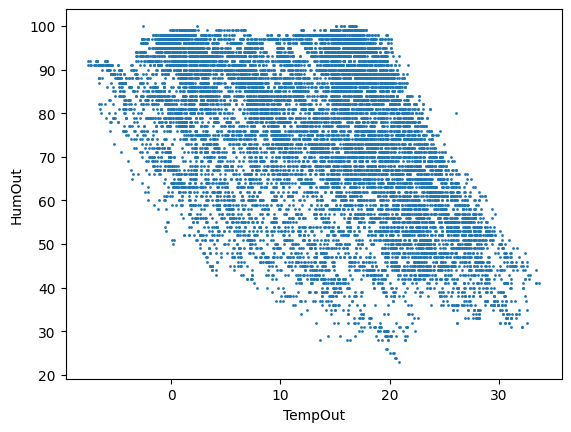

In [11]:
df_all.plot.scatter(x='TempOut',y='HumOut', s=1)

In [12]:
df_dask = dask.dataframe.read_csv(
    data_dir/"*.txt", sep=r'\s+', names=columns, skiprows=3, na_values=['---', '------'], assume_missing=True
)

# Fill missing integer columns with -1 and cast to int after loading
for col in ['HumIn', 'HumOut', 'SolarRad', 'SolarRadHi']:
   df_dask[col] = df_dask[col].fillna(-1).astype('int64')

In [13]:
df_dask.HumOut.unique().min().compute()

np.float64(-1.0)

<Axes: xlabel='TempOut', ylabel='HumOut'>

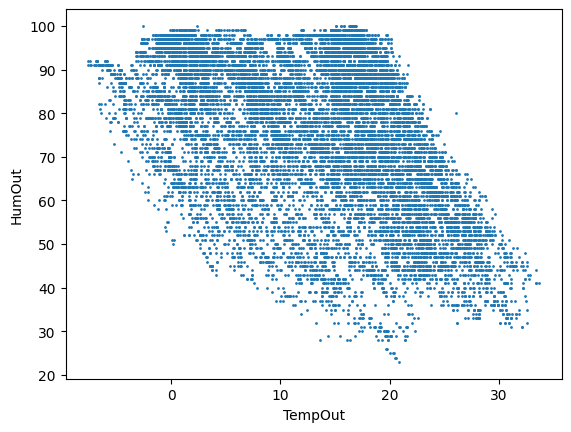

In [14]:
df_dask.compute().plot.scatter(x='TempOut',y='HumOut', s=1)

In [15]:
dask_out_path = data_dir/"meteo_dask.h5"
df_dask.to_hdf(dask_out_path, key='df', mode='w');

# print size of the created file
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 4.01 MB


In [16]:
df_dask.to_hdf(dask_out_path, key='df', mode='w', complevel=5);
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 0.76 MB


In [17]:
# exercise: extend the notebook to read the data from 2006 until now

In [18]:
# work on datatype, replace some object types with categorical or string